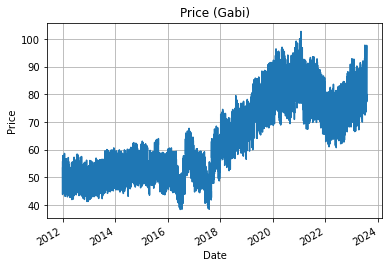

,Price
Date,
2023-07-27,94.38
2023-07-28,97.77
2023-07-29,77.48
2023-07-30,79.77
2023-07-31,79.93


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#--------Data manipulation-----------#

df = pd.read_excel('Gabi.xlsx')


#setting index
df.set_index(pd.Index(['Month','Day','Price']), inplace=True)

#transpose horizontal to vertical
df = df.T

#reset the index
df.reset_index(inplace=True)

df.rename(columns={'index': 'Year'}, inplace=True)

df['Year'].replace(r'^Unnamed.*', pd.NA, regex=True, inplace=True)
df['Year'].fillna(method='ffill', inplace=True)
df['Month'].fillna(method='ffill', inplace=True)


df['Day'] = df['Day'].astype(int)
df['Date'] = df['Year'].astype(str) + ' ' + df['Month'].astype(str) + ' ' + df['Day'].astype(str)

df['Date'] = pd.to_datetime(df['Date'], format='%Y %B %d')
df.set_index('Date', inplace=True)

#drops the column
df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

df['Price'] = df['Price'].astype(float)
ts = pd.Series(data=df['Price'])

#ploting
ts.plot(title='Price (Gabi)', xlabel='Date', ylabel='Price')
plt.autoscale()
plt.grid(which='both')
plt.show()

ts
df.tail()

In [2]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result = adfuller(ts)

# Print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# Check if the p-value is less than the significance level (e.g., 0.05)
if result[1] <= 0.05:
    print("Reject the null hypothesis; Time series is stationary")
else:
    print("Fail to reject the null hypothesis; Time series is non-stationary")


ADF Statistic: -0.5595101677661956
p-value: 0.8798711500766038
Fail to reject the null hypothesis; Time series is non-stationary


ADF Statistic after differencing: -18.402751816202667
p-value after differencing: 2.1909444735483703e-30


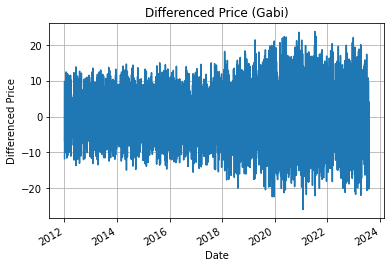

In [3]:
# First-order difference
ts_diff = ts.diff().dropna()

# Check stationarity again
result_diff = adfuller(ts_diff)
print('ADF Statistic after differencing:', result_diff[0])
print('p-value after differencing:', result_diff[1])

# Plot differenced time series
ts_diff.plot(title='Differenced Price (Gabi)', xlabel='Date', ylabel='Differenced Price')
plt.autoscale()
plt.grid(which='both')
plt.show()


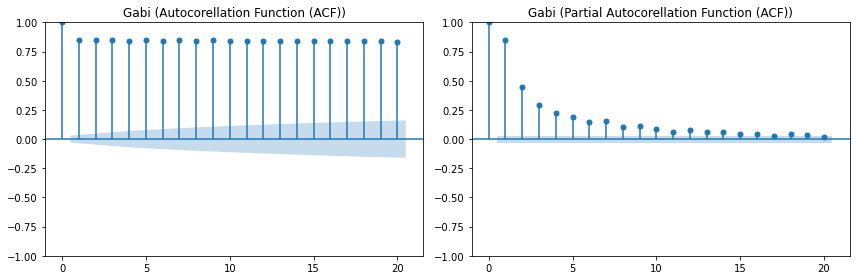

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting ACF and PACF side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF
plot_acf(ts, lags=20, ax=ax1)
ax1.set_title('Gabi (Autocorellation Function (ACF))')

# PACF
plot_pacf(ts, lags=20, ax=ax2)
ax2.set_title('Gabi (Partial Autocorellation Function (ACF))')

plt.tight_layout()
plt.show()


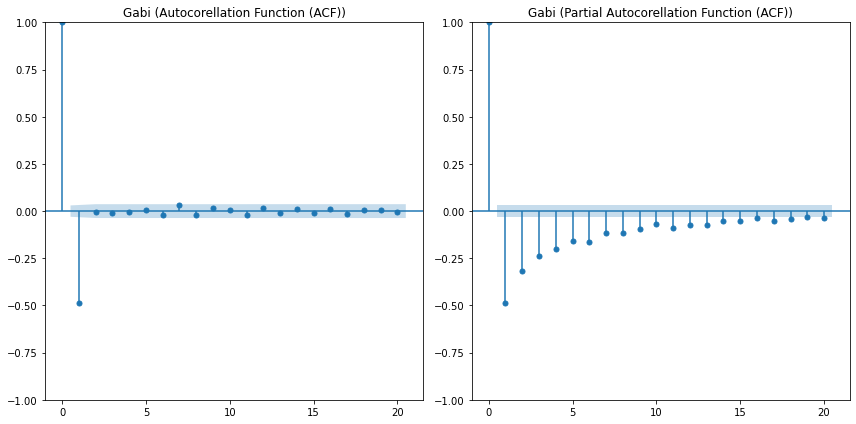

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Differencing the time series
ts_diff = ts.diff().dropna()

# Plotting ACF and PACF
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(ts_diff, lags=20, ax=plt.gca())
plt.title('Gabi (Autocorellation Function (ACF))')

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(ts_diff, lags=20, ax=plt.gca())
plt.title('Gabi (Partial Autocorellation Function (ACF))')

plt.tight_layout()
plt.show()


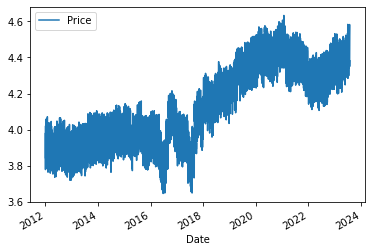

In [6]:
import numpy as np
df= np.log(df)
df.plot()

df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)  # Make sure the index is sorted

# Set frequency explicitly
df = df.asfreq('D')


## Monthly

In [7]:
from itertools import product
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Resample the data to monthly frequency
df_monthly = df.resample('M').mean()

# Set frequency explicitly
df_monthly.index.freq = 'M'

# Fit the ARIMA model (replace with your chosen order)
order = (48,1,47)  # Example order, you may need to adjust this based on your data and analysis
model = sm.tsa.ARIMA(df_monthly['Price'], order=order)
results = model.fit()

# Forecast future values (replace steps with the number of steps you want to forecast)
forecast_steps = 12  # Assuming you want to forecast 12 months (1 year)
forecast = results.get_forecast(steps=forecast_steps)

# Get the predicted values, confidence intervals, and dates
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
forecast_dates = predicted_values.index

# Convert log-transformed values back to original scale
forecasted_values_original_scale = np.exp(predicted_values)

# Extract forecasted values as a list
forecasted_values_list = forecasted_values_original_scale.tolist()

print('Forecasted Values')
# Print the list of forecasted values with dates
for date, value in zip(forecast_dates, forecasted_values_list):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

mse = mean_squared_error(df_monthly['Price'], results.fittedvalues)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_monthly['Price'], results.fittedvalues)
mape = np.mean(np.abs((df_monthly['Price'] - results.fittedvalues) / df_monthly['Price'])) * 100

print()
print('Error Metrics')
# Print the metrics as percentages
print(f'MSE: {mse:.2%}')
print(f'RMSE: {rmse:.2%}')
print(f'MAE: {mae:.2%}')
print(f'MAPE: {mape:.2f}%')



residuals = results.resid



Forecasted Values
2023-08-31: 86.19
2023-09-30: 84.33
2023-10-31: 83.60
2023-11-30: 86.38
2023-12-31: 88.94
2024-01-31: 90.55
2024-02-29: 92.97
2024-03-31: 92.36
2024-04-30: 92.42
2024-05-31: 93.58
2024-06-30: 94.12
2024-07-31: 97.42

Error Metrics
MSE: 11.21%
RMSE: 33.48%
MAE: 4.67%
MAPE: 1.17%


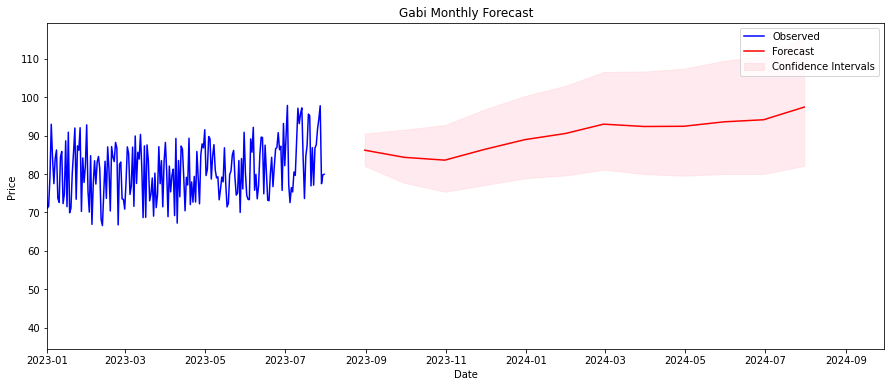

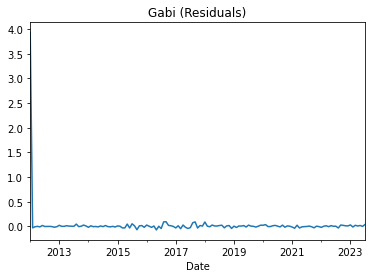

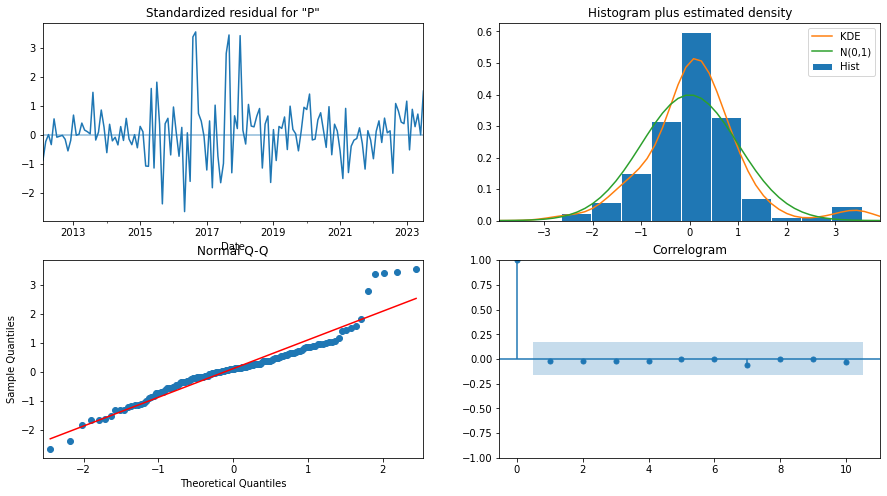

count    139.000000
mean       0.031205
std        0.334561
min       -0.072124
25%       -0.010185
50%        0.003166
75%        0.015634
max        3.934971
dtype: float64
Mean of Residuals: 0.031204575176847354


In [8]:
import matplotlib.pyplot as plt

# Plot the observed values

plt.figure(figsize=(15, 6))

plt.plot(ts, label='Observed', color='blue')

# Plot the forecasted values
plt.plot(predicted_values.index, forecasted_values_original_scale, label='Forecast', color='red')

# Add confidence intervals
confidence_intervals = forecast.conf_int()
plt.fill_between(confidence_intervals.index, np.exp(confidence_intervals.iloc[:, 0]), np.exp(confidence_intervals.iloc[:, 1]), color='pink', alpha=0.3, label='Confidence Intervals')

#Gabi Monthly Forecast plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.title('Gabi Monthly Forecast')
plt.xlim(pd.Timestamp('2023-01-01'), ts.index[-1] + pd.DateOffset(months=14))  # Increase x-axis limits

plt.show()

residuals.plot(title="Gabi (Residuals)")
plt.show()

results.plot_diagnostics(figsize=(15, 8))
plt.show()

print(residuals.describe())

print(f"Mean of Residuals: {results.resid.mean()}")

In [9]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  139
Model:               ARIMA(48, 1, 47)   Log Likelihood                 301.785
Date:                Mon, 11 Dec 2023   AIC                           -411.569
Time:                        22:17:56   BIC                           -130.553
Sample:                    01-31-2012   HQIC                          -297.371
                         - 07-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1789     64.527      0.003      0.998    -126.291     126.649
ar.L2         -0.0559     52.695     -0.001      0.999    -103.336     103.224
ar.L3         -0.2655     61.699     -0.004      0.9

## Weekly

In [10]:
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Resample the data to weekly frequency and calculate the mean
df_weekly = df.resample('W').mean()

# Set frequency explicitly
df_weekly.index.freq = 'W'

df_weekly = df_weekly.fillna(method='ffill')

# Fit the ARIMA model (replace with your chosen order)
order = (48,1,47)  # Example order, you may need to adjust this based on your data and analysis
model = sm.tsa.ARIMA(df_weekly['Price'], order=order)
results = model.fit()

# Forecast future values (replace steps with the number of steps you want to forecast)
forecast_steps = 6  # Assuming you want to forecast 12 weeks (3 months)

forecast = results.get_forecast(steps=forecast_steps)

# Get the predicted values, confidence intervals, and dates
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()
forecast_dates = forecast.predicted_mean.index

# Convert log-transformed values back to the original scale
forecasted_values_original_scale = np.exp(predicted_values)

# Extract forecasted values as a list
forecasted_values_list = forecasted_values_original_scale.tolist()

print('Forecasted Values (Weekly Frequency)')
# Print the list of forecasted values with dates
for date, value in zip(forecast_dates, forecasted_values_list):
    print(f"{date.strftime('%Y-%m-%d')}: {value:.2f}")

mse = mean_squared_error(df_weekly['Price'], results.fittedvalues)
rmse = np.sqrt(mse)
mae = mean_absolute_error(df_weekly['Price'], results.fittedvalues)
mape = np.mean(np.abs((df_weekly['Price'] - results.fittedvalues) / df_weekly['Price'])) * 100

print()
print('Error Metrics')
# Print the metrics as percentages
print(f'MSE: {mse:.2%}')
print(f'RMSE: {rmse:.2%}')
print(f'MAE: {mae:.2%}')
print(f'MAPE: {mape:.2f}%')

residuals = results.resid


Forecasted Values (Weekly Frequency)
2023-08-13: 84.00
2023-08-20: 84.72
2023-08-27: 83.43
2023-09-03: 82.13
2023-09-10: 85.54
2023-09-17: 84.99

Error Metrics
MSE: 2.81%
RMSE: 16.75%
MAE: 3.59%
MAPE: 0.88%


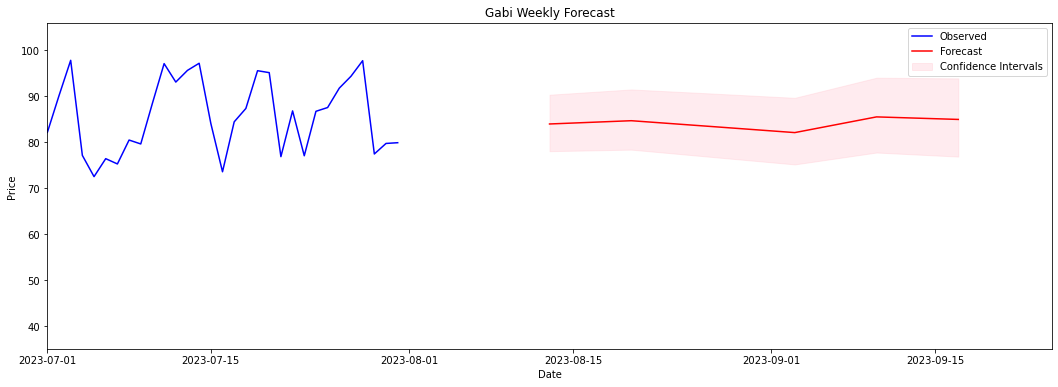

In [11]:
import matplotlib.pyplot as plt

# Plot the observed values
plt.figure(figsize=(18, 6))  # Increase the figure size

# Plot the observed values
plt.plot(ts, label='Observed', color='blue')

# Plot the forecasted values
plt.plot(predicted_values.index, forecasted_values_original_scale, label='Forecast', color='red')

# Add confidence intervals
confidence_intervals = forecast.conf_int()
plt.fill_between(confidence_intervals.index, np.exp(confidence_intervals.iloc[:, 0]), np.exp(confidence_intervals.iloc[:, 1]), color='pink', alpha=0.3, label='Confidence Intervals')

# Gabi Weekly Forecast plot
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Set x-axis limits to start from July 2023
plt.xlim(pd.Timestamp('2023-07-01'), ts.index[-1] + pd.DateOffset(weeks=8))  # Increase x-axis limits

# Adjust y-axis limits if needed
#plt.ylim(0, max(ts.max(), forecasted_values_original_scale.max()) * 1.2)

plt.title('Gabi Weekly Forecast')
plt.show()


In [12]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  606
Model:               ARIMA(48, 1, 47)   Log Likelihood                1124.113
Date:                Mon, 11 Dec 2023   AIC                          -2056.225
Time:                        22:20:09   BIC                          -1633.323
Sample:                    01-01-2012   HQIC                         -1891.659
                         - 08-06-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2963      6.094     -0.049      0.961     -12.241      11.648
ar.L2          0.0236      6.809      0.003      0.997     -13.321      13.368
ar.L3          0.0110      6.640      0.002      0.9

In [13]:
###############################################################################################################################